# Regresión harmónica

En este tutorial ajustarás un modelo de regresión harmónica a una serie de tiempo, para ello se genera una descomposición de Fourier a las estacionalidades largas. Este modelo es aplicable cuando estos ciclos se presentan de manera estable en series extensas.


**Contenido**
1. [Datos y Modelamiento:](#1)
    1. [Importación de librerías requeridas](#2)
    1. [Importación de datos](#3)
1. [Visualización](#4)
1. [Modelo de regresión harmónica](#6)
    1. [Model checking](#7)
1. [Pronóstico](#12)   
                

<a id="1"></a> <br>
## 1. Datos y modelamiento

Comenzaremos con los pasos usuales de importación de datos y librerías requeridas. Posteriormente, procedemos con el modelo de regresión.

<a id="2"></a> <br>
### A. Importación de librerías requeridas
Importamos las librerías requeridas para la importación de datos de la FRED.

In [1]:
# Referenciamos las librerías usuales de trabajo.
library(forecast)
library(tseries)
library(quantmod)
library(ggplot2)
#Podemos deshabilitar los avisis de warnings para comodidad de lectura.
options(warn = - 1)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR



<a id="3"></a> <br>
### B. Importación de los datos

In [2]:
#### Vamos a emplear una serie de ventas minoristas en EUA, particularmente, las ventas de Concesionarios de autos nuevos. EL ticker es extenso.
getSymbols("MRTSSM44111USN",src="FRED")
##Damos un vistazo a la serie:
head(MRTSSM44111USN)
tail(MRTSSM44111USN)

[1] "MRTSSM44111USN"

           MRTSSM44111USN
1992-01-01          24056
1992-02-01          25041
1992-03-01          28018
1992-04-01          27982
1992-05-01          28924
1992-06-01          30591

           MRTSSM44111USN
2022-08-01          99049
2022-09-01          91670
2022-10-01          94219
2022-11-01          88587
2022-12-01          94966
2023-01-01          89073

In [17]:
###Eliminamos los valores faltantes:
VENTAS<-na.omit(MRTSSM44111USN/1000)
colnames(VENTAS)<-c("VENTAS")
head(VENTAS)

           VENTAS
1992-01-01 24.056
1992-02-01 25.041
1992-03-01 28.018
1992-04-01 27.982
1992-05-01 28.924
1992-06-01 30.591

<a id="4"></a> <br>
### 2. Visualización

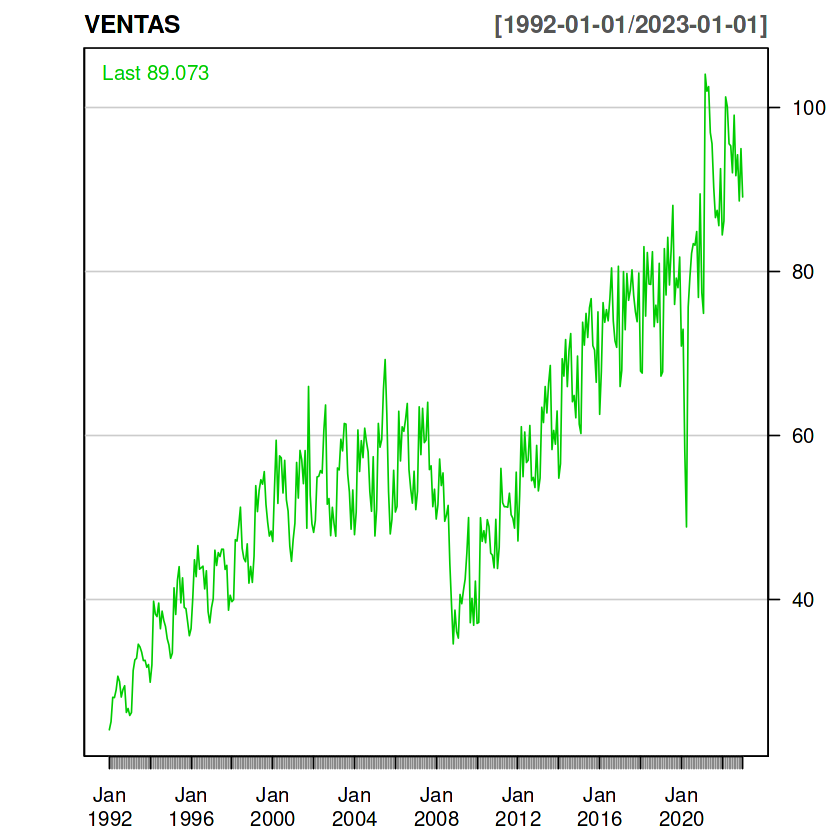

In [18]:
##Generamos una visualización de la serie
chartSeries(VENTAS,theme="white") 

Como podemos ver, al parecer existen patrones estacionales en la serie. Podemos proceder con una descomposición a la misma.

<a id="6"></a> <br>
## 3. Modelo de regresión harmónica
Aplicamos la función de regresión, para ello, requerimos convertir la serie a un formato tipo ts(). La frecuencia de la serie es mensual.

In [32]:
#Pasamos la serie a formato ts indicando una frecuencia mensual:
ventas.ts=ts(VENTAS, start= c(1992,01),frequency = 12)

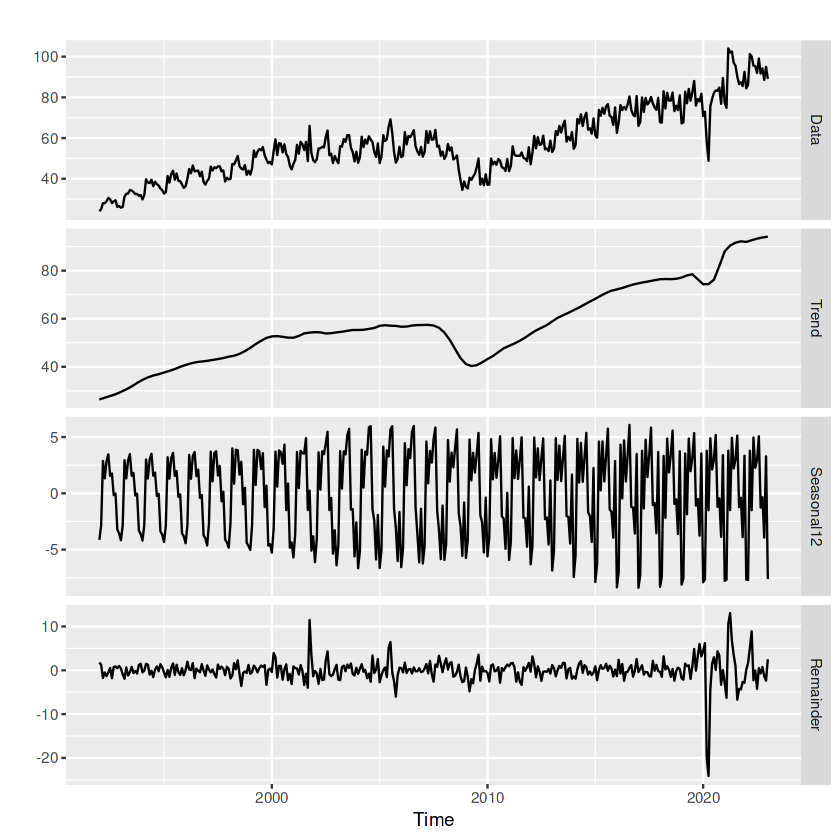

In [31]:
#Podemos generar una descomposición así como una visualización de los componentes de la serie.
mstl(ventas.ts)%>%autoplot()

Como podemos observar, el componente estacional es evidente en la composición de la serie.

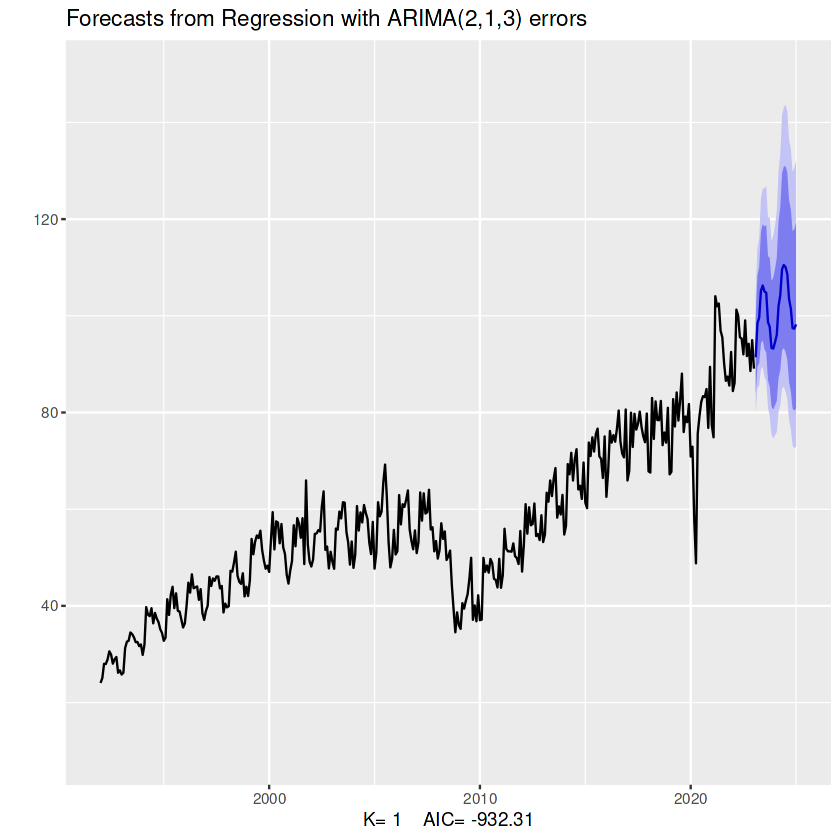

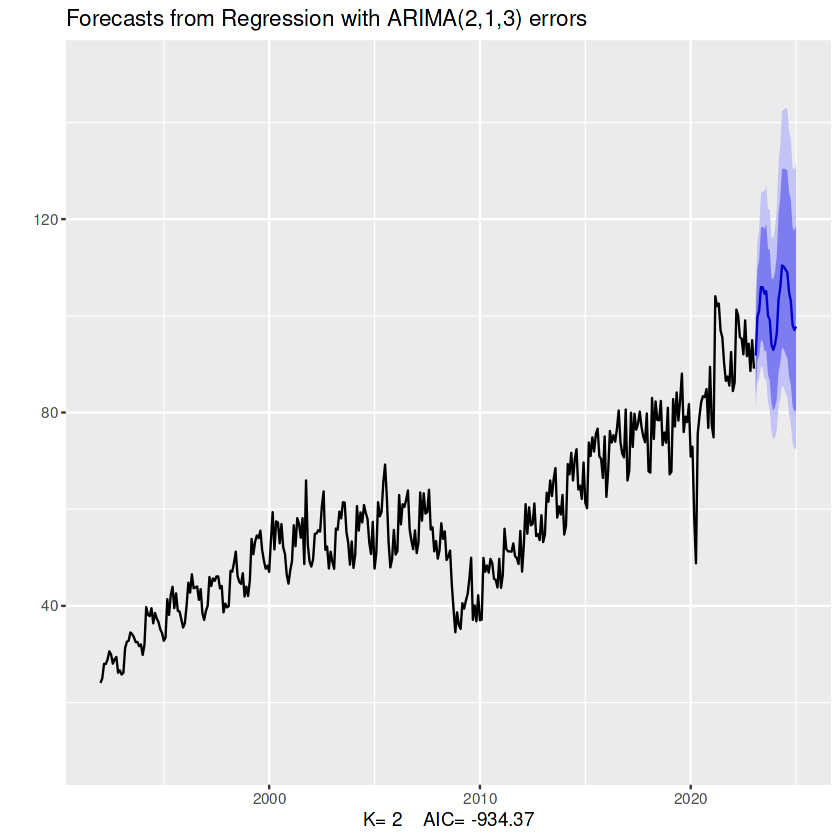

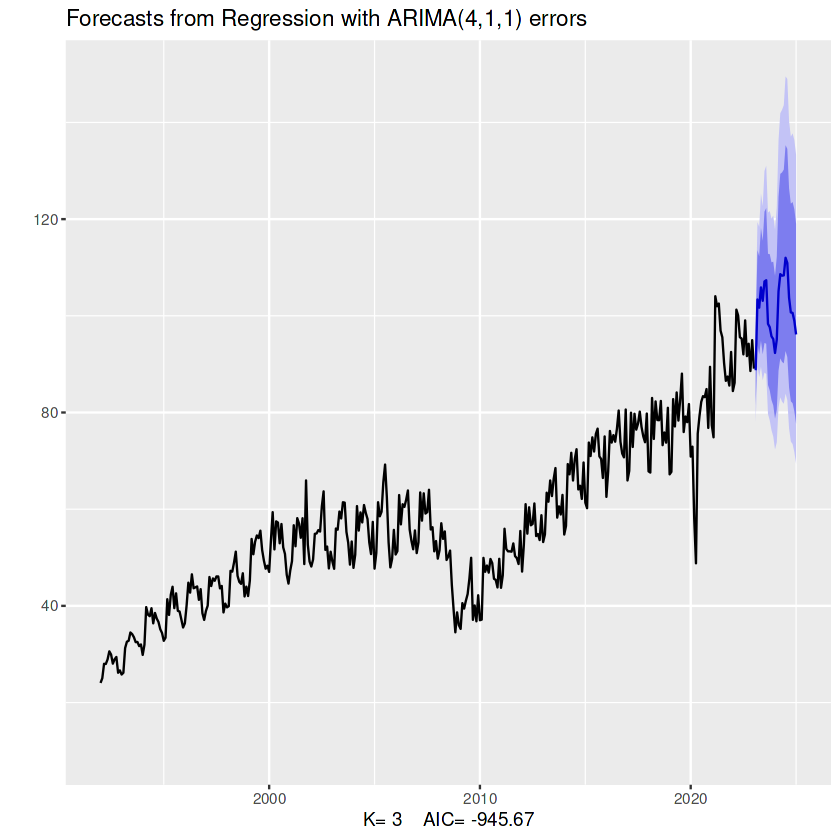

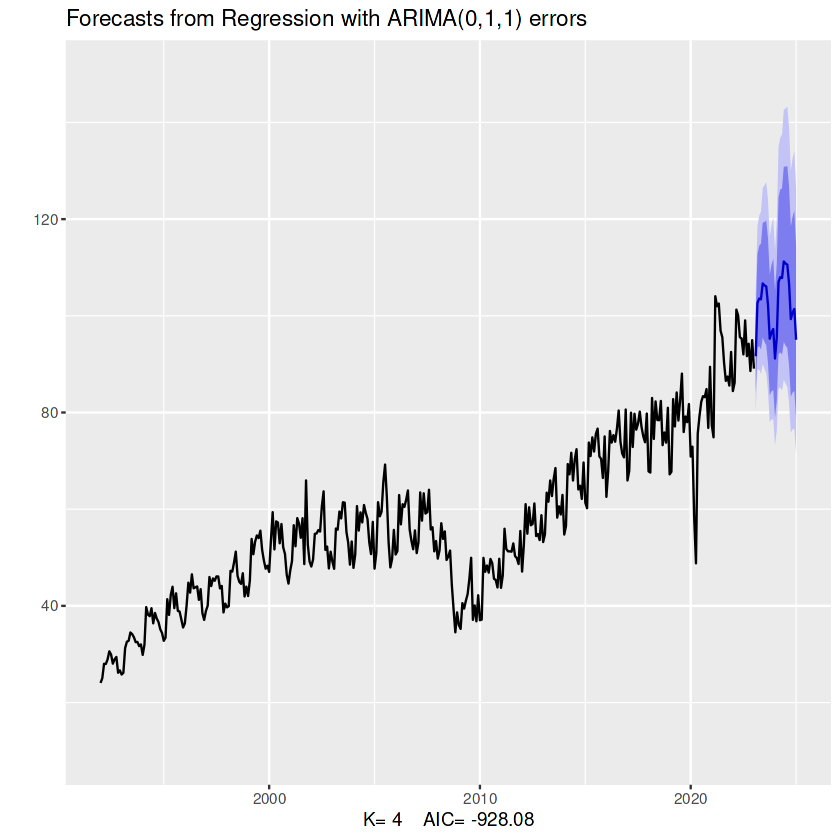

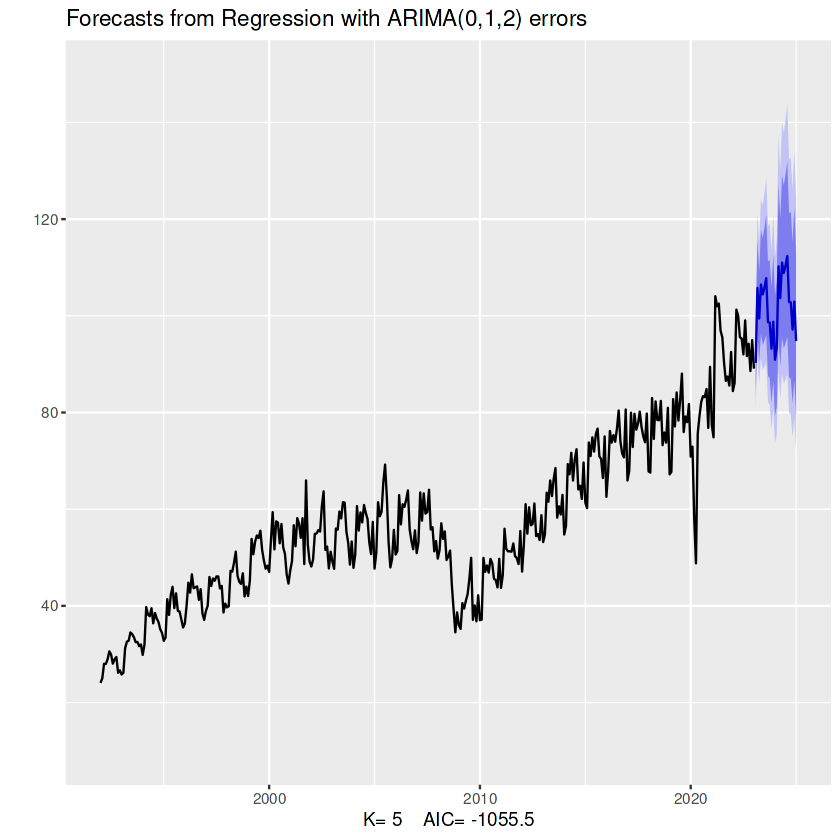

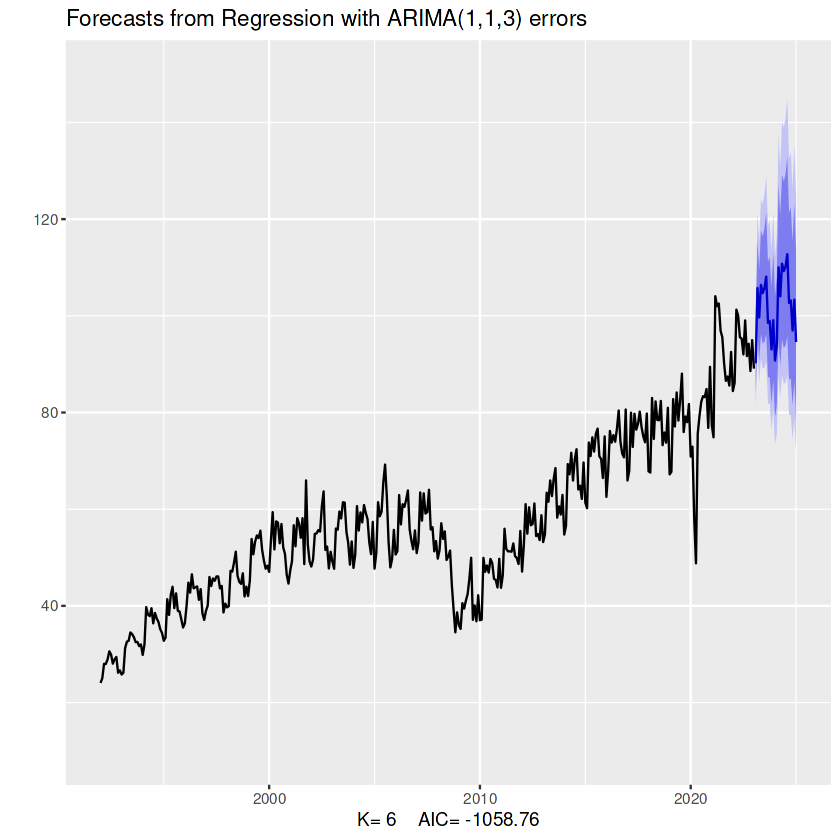

In [22]:
# Aplicamos la función de regresión, generamos una función de regresión a diferentes valores del parámetro k.
data1<-window(ventas.ts)
plots<- list()

#Revisamos para distintos valores del parámetro K:
for (i in seq(6)) {
  fit <- auto.arima(data1, xreg = fourier(data1, K = i),
                    seasonal = FALSE, lambda = 0)
  plots[[i]] <- autoplot(forecast(fit,
                                  xreg=fourier(data1, K=i, h=24))) +
    xlab(paste("K=",i,"   AIC=",round(fit[["aic"]],2))) +
    ylab("") + ylim(10,150)
}
gridExtra::grid.arrange(plots[[1]])
gridExtra::grid.arrange(plots[[2]])
gridExtra::grid.arrange(plots[[3]])
gridExtra::grid.arrange(plots[[4]])
gridExtra::grid.arrange(plots[[5]])
gridExtra::grid.arrange(plots[[6]])

De acuerdo con los plots, podemos ver que a medida que aumenta el valor de K, disminuye el valor de AIC, por lo tanto, elegimos K=6 como parámetro del modelo óptimo.

In [33]:
#Ahora, definimos los términos de Fourier como variables regresoras:
regresores=fourier(ventas.ts, K=6)

In [24]:
# Construimos el modelo, empleamos la función de auto.arima, con la opción de seasonal en FALSE, para que la introducción de te´rminos fourier modele la estacionalidad.
mod_Ventas=auto.arima(ventas.ts, xreg=regresores, seasonal=FALSE, lambda=0)
summary(mod_Ventas)

Series: ventas.ts 
Regression with ARIMA(1,1,3) errors 
Box Cox transformation: lambda= 0 

Coefficients:
          ar1     ma1      ma2      ma3   drift    S1-12    C1-12    S2-12
      -0.7999  0.5024  -0.5243  -0.1521  0.0035  -0.0060  -0.0761  -0.0065
s.e.   0.1895  0.2011   0.0647   0.0971  0.0013   0.0056   0.0056   0.0043
        C2-12    S3-12   C3-12    S4-12   C4-12   S5-12   C5-12   C6-12
      -0.0082  -0.0182  0.0194  -0.0062  0.0206  0.0328  0.0184  0.0028
s.e.   0.0044   0.0037  0.0037   0.0032  0.0032  0.0026  0.0026  0.0009

sigma^2 = 0.003239:  log likelihood = 546.38
AIC=-1058.76   AICc=-1057.03   BIC=-992.14

Training set error measures:
                     ME     RMSE     MAE        MPE     MAPE      MASE
Training set 0.03495718 3.350896 2.20942 -0.1570911 3.943805 0.5085328
                   ACF1
Training set 0.04907643

Como podemos observar, el resultado de regresión nos imprime los términos AR, MA, así como los términos de seno y coseno de las funciones de Fourier, que indican la estacionalidad de 12.

<a id="7"></a> <br>
### A. Revisión de los residuales

Como es usual, procedemos con la revisión de los residuales del modelo obtenido.

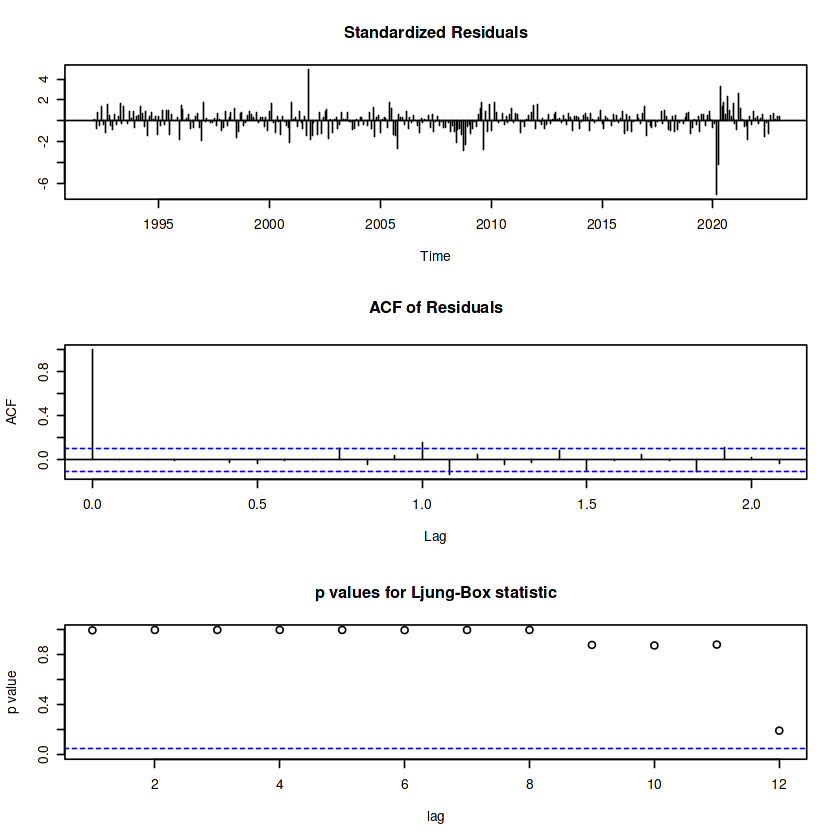

In [25]:
tsdiag(mod_Ventas,gof=12) 

Como podemos observar, los resultados son muy buenos, ya que no encontramos residuales correlacionados.

<a id="11"></a> <br>
## 3. Pronóstico
Procedemos con el pronóstico de la serie.

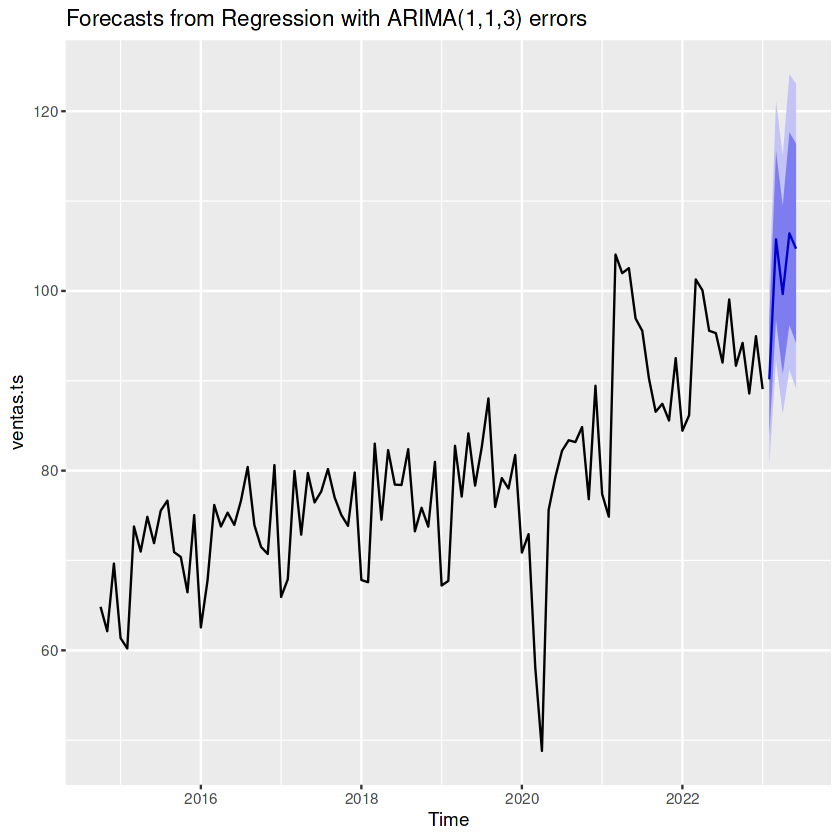

In [29]:
#Generamos la función de pronóstico concatenada, para facilidad, con la función de visualización.
autoplot(forecast(mod_Ventas, xreg =fourier(ventas.ts, K=6, h=5)), include=100)


Finalmente observamos que el comportamiento del pronóstico es comprensible dado el comportamiento de los componentes de la serie.

En este tutorial, aprendimos cómo desarrollar el pronóstico de una serie mediante el modelo de regresión harmónica o también llamada regresión dinámica harmónica. Empleamos una serie histórica la cual presentaba estacionariedad estable en el tiempo. 